In [41]:
using ITensors
using HDF5
using Plots
using Plots.PlotMeasures

Load in the trained MPS

In [9]:
f = h5open("ECG200_chi_max_10.h5", "r");
W = read(f, "mps", MPS);

# Slice the MPS

In [15]:
findindex(W[end], "f(x)")

(dim=2|id=118|"f(x)")

In [17]:
norm(W)

0.999999999999995

In [29]:
function SliceMPS(W::MPS)
    """Gets the label index of the MPS and slices according to the number of classes (dim of the label index)"""
    """Assume one-hot encoding scheme i.e. class 0 = [1, 0], class 1 = [0, 1], etc. """
    dec_index = findindex(W[end], "f(x)")
    if dec_index == nothing
        error("Label index not found on the first site of the MPS!")
    end

    n_states = ITensors.dim(dec_index)
    states = []
    for i=1:n_states
        state = deepcopy(W)
        if !isapprox(norm(state), 0)
            normalize!(state)
        end
        decision_state = onehot(dec_index => (i))
        println("Class $(i-1) state: $(vector(decision_state))")
        state[end] *= decision_state
        normalize!(state)
        push!(states, state)
    end

    return states
end;

In [32]:
s0, s1 = SliceMPS(W);

Class 0 state: [1.0, 0.0]
Class 1 state: [0.0, 1.0]


In [35]:
function entropy_von_neumann(ψ::MPS, b::Int)
    psi = deepcopy(ψ)
    s = siteinds(psi)
    orthogonalize!(psi, b) # change orthogonality center to site B
    #print(norm(psi))
    if b == 1
        _, S = svd(psi[b], (siteind(psi, b),))
    else
        _, S = svd(psi[b], (linkind(psi, b-1), s[b]))
    end
    SvN = 0.0
    for n in 1:ITensors.dim(S, 1)
        p = S[n, n]^2
        if p > 1E-12
            SvN -= p * log(p)
        end
    end

    return SvN
end;

In [38]:
entropy_s0 = [entropy_von_neumann(s0, site_idx) for site_idx in 1:length(s0)]
entropy_s1 = [entropy_von_neumann(s1, site_idx) for site_idx in 1:length(s1)]

96-element Vector{Float64}:
 0.3346856306145571
 0.5748124556011072
 0.7877483402474248
 0.9751797128672891
 1.1761942896274717
 1.3789884251549895
 1.5127409065193491
 1.6149535094893468
 1.6958437481691306
 1.794601469607057
 ⋮
 0.46950998957289786
 0.458157100358996
 0.39750627103857344
 0.37060246528345164
 0.3352408055832036
 0.2588965638320976
 0.1542733509968146
 0.08569440639176777
 4.884981308350677e-15

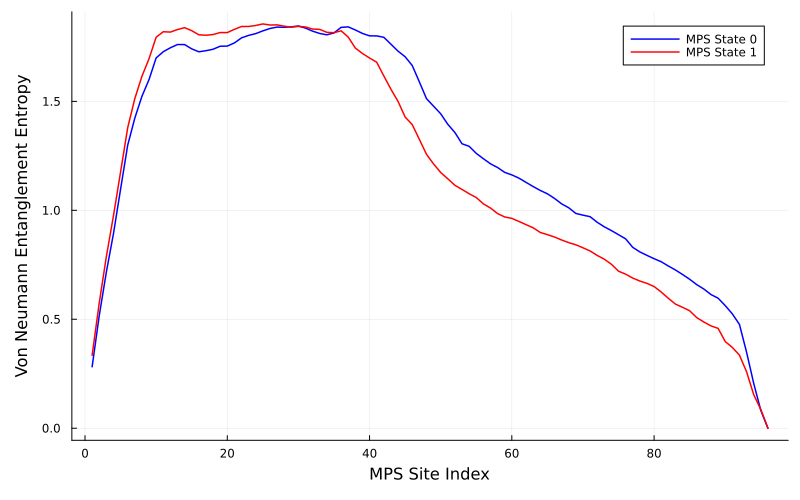

In [42]:
plot(entropy_s0, label="MPS State 0", lw=1.5, color=:blue, size=(800,500), left_margin=5mm, bottom_margin=5mm)
plot!(entropy_s1, label="MPS State 1", lw=1.5, color=:red)
xlabel!("MPS Site Index")
ylabel!("Von Neumann Entanglement Entropy")

# Start with state 0

In [58]:
s0_copy = deepcopy(s0);

In [59]:
orthogonalize!(s0, 1);

In [60]:
s = siteinds(W);

Get the 1-site RDM for site 1

In [61]:
ρ1 = prime(s0_copy[1], s[1]) * dag(s0_copy[1])
ρ1 = matrix(ρ1)

2×2 Matrix{Float64}:
 0.319008  0.37761
 0.37761   0.680992

In [63]:
tr(ρ1), isequal(ρ1, adjoint(ρ1))

(1.0000000000000053, true)

Construct interval from $\theta = 0$ to $\theta = \pi/2$ and discretise into 100 values.

In [76]:
theta_range = collect(range(0, pi/2, 100));
states = [[cos(theta), sin(theta)] for theta in theta_range];

Map each value to its corresponding state vector. Let's try the $\ket{0}$ state.

In [88]:
psi = states[1]

2-element Vector{Float64}:
 1.0
 0.0

The probability of the $\ket{0}$ state is given by $\braket{\psi | \rho | \psi}$ where $\rho$ is the 1 site RDM and $\ket{\psi}$ is the target state.

In [89]:
proba_0_state = psi' * ρ1 * psi

0.31900827364146045

So we have a probability of 0.31900827364146045 of being in the zero state. Now let's repeat for all states in the interval.

In [90]:
probas = []
for i=1:length(states)
    psi = states[i]
    expect = psi' * ρ1 * psi
    push!(probas, expect)
end

In [106]:
probas

100-element Vector{Any}:
 0.31900827364146045
 0.33108019319296567
 0.34332220067120667
 0.3557219694123634
 0.36826701390039696
 0.3809447023389057
 0.3937422693702736
 0.40664682892930376
 0.4196453872183926
 0.4327248557911835
 ⋮
 0.7700268002028637
 0.7597362710691732
 0.749184209527417
 0.7383812406091076
 0.7273382419882175
 0.7160663330282827
 0.7045768635861472
 0.6928814025836186
 0.6809917263585448

In [112]:
probas_normalised = probas ./ sum(probas);

Note that because we are calculating probabilites based on the assumption that the quantum system is independently observed to be in each specific state, these quantities reflect the absolute probability. We need to normalise the values to get the relative probabilities of being in each possible state in order to do sampling.

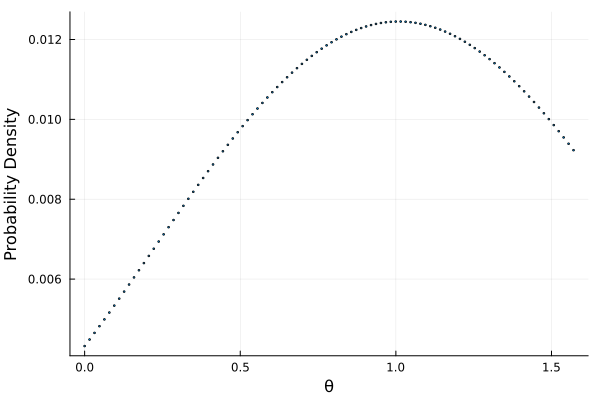

In [115]:
scatter(theta_range, probas_normalised, xlabel="θ", ylabel="Probability Density", label="", ms=1)

Now that we have our probabilities for each "bin"/discretised value, let's generate a sample using a random number generator and our cumulative distribution function above.

In [122]:
cdf = cumsum(probas_normalised)

100-element Vector{Float64}:
 0.004322779080991819
 0.008809140882610231
 0.013461390211947637
 0.018281664841417702
 0.023271933356199762
 0.028433993172040397
 0.033769468725408154
 0.03927980983782371
 0.04496629025601251
 0.050830006369349756
 ⋮
 0.9218240084017001
 0.9321189516085328
 0.9422709072045007
 0.9522764752239974
 0.9621324031012968
 0.9718355889456117
 0.9813830846644349
 0.990772098932018
 1.0000000000000004

Generate random value and then select a bin using the cdf..

In [152]:
r = rand()
sampled_bin_index = findfirst(>=(r), cdf)

94

Now convert the selected index back into a raw time-series value

In [153]:
selected_angle = theta_range[sampled_bin_index]

1.4755965494133876

In [155]:
states[sampled_bin_index]

2-element Vector{Float64}:
 0.09505604330418281
 0.9954719225730846

This is the value of $\theta$, our angle. We can then get back our original time-series value: $x = 2 \theta / \pi$

In [154]:
x = (2 * selected_angle) / pi

0.9393939393939393

This is now our measurement for the first site. Let's construct a projector to project the MPS onto this state at the first site and continue our sampling process...

In [156]:
site_1_projector_matrix = states[sampled_bin_index] * states[sampled_bin_index]'

2×2 Matrix{Float64}:
 0.00903565  0.0946256
 0.0946256   0.990964

Convert the matrix into a single site MPO in ITensor

In [159]:
site_1_projector_operator = op(site_1_projector_matrix, s[1]);
@show site_1_projector_operator

site_1_projector_operator = ITensor ord=2
Dim 1: (dim=2|id=195|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=195|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 0.009035651368646678  0.09462562218020525
 0.09462562218020525   0.9909643486313533


ITensor ord=2 (dim=2|id=195|"S=1/2,Site,n=1")' (dim=2|id=195|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Make the measurement by applying the operator to site 1

In [160]:
site_1_before_measure = deepcopy(s0[1])

ITensor ord=2 (dim=2|id=195|"S=1/2,Site,n=1") (dim=2|id=268|"Link,l=1")
NDTensors.Dense{Float64, Vector{Float64}}

In [161]:
site_1_after_measure = site_1_before_measure * site_1_projector_operator

ITensor ord=2 (dim=2|id=268|"Link,l=1") (dim=2|id=195|"S=1/2,Site,n=1")'
NDTensors.Dense{Float64, Vector{Float64}}

Now unprime the site index before placing the new site back into the MPS

In [162]:
noprime!(site_1_after_measure)

ITensor ord=2 (dim=2|id=268|"Link,l=1") (dim=2|id=195|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

Add back into MPS

In [163]:
s0[1] = site_1_after_measure

ITensor ord=2 (dim=2|id=268|"Link,l=1") (dim=2|id=195|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}

In [165]:
norm(s0)

0.8655542787875391

Re-normalise

In [167]:
normalize!(s0);

### Site 2

We have conditioned our MPS on the first site, now let's get the RDM for the second site.

In [169]:
orthogonalize!(s0, 2);

In [171]:
ρ2 = prime(s0[2], s[2]) * dag(s0[2])
ρ2 = matrix(ρ2)

2×2 Matrix{Float64}:
 0.166947  0.264722
 0.264722  0.833053

In [172]:
tr(ρ2), isequal(ρ2, adjoint(ρ2))

(1.0, true)

In [173]:
theta_range = collect(range(0, pi/2, 100));
states = [[cos(theta), sin(theta)] for theta in theta_range];

In [174]:
probas = []
for i=1:length(states)
    psi = states[i]
    expect = psi' * ρ2 * psi
    push!(probas, expect)
end

In [175]:
probas_normalised = probas ./ sum(probas);

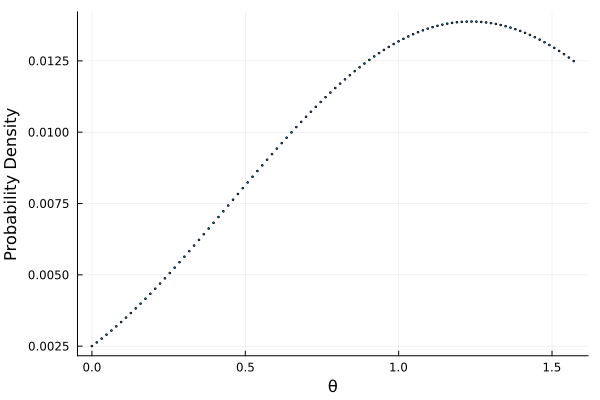

In [176]:
scatter(theta_range, probas_normalised, xlabel="θ", ylabel="Probability Density", label="", ms=1)

In [177]:
cdf = cumsum(probas_normalised)

100-element Vector{Float64}:
 0.0025035984624034425
 0.005135667263110797
 0.007901106168774824
 0.01080468065365789
 0.013851017101203345
 0.01704459814565954
 0.020389758158447145
 0.023890678883814503
 0.027551385228175667
 0.03137574120737081
 ⋮
 0.8968981002517534
 0.9101427581794802
 0.923296574136775
 0.9363538533827943
 0.9493089983809796
 0.9621565144353025
 0.9748910152229577
 0.9875072282179338
 0.9999999999999994

In [178]:
r = rand()
sampled_bin_index = findfirst(>=(r), cdf)

42

In [180]:
selected_angle = theta_range[sampled_bin_index]

0.6505318121069774

In [181]:
x = (2 * selected_angle) / pi

0.4141414141414142